<a href="https://colab.research.google.com/github/eliabrodsky/eliabrodsky/blob/main/Emotion_Capture_using_DeepFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capture Video and Audio for emotion and speech to text

## Capture Video and Emotion

In [ ]:
#deepface: a pre-trained model of emotion capture 
#from face recognition: https://github.com/serengil/deepface

!pip install deepface --q

     |████████████████████████████████| 65 kB 2.0 MB/s 
     |████████████████████████████████| 87 kB 3.1 MB/s 
     |████████████████████████████████| 2.3 MB 36.7 MB/s 


In [ ]:
#import packages
from deepface import DeepFace

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import pandas as pd
import PIL
import io
import html
import time

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
#create directory to save images
!mkdir database

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()

  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

**The Video Stream will start after this code block**



In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Next section starts video

In [ ]:
#@title Prepare Packages and Data {run: "auto"}
#@markdown Here we will record the video, track the face and capture emotion <br>
#@markdown ![The Cancer Genome Atlas](https://raw.githubusercontent.com/eliabrodsky/eliabrodsky/a497fc013c9d502617e36592419f4aa5ddc9d079/image-recognition-emotion.jpg "TCGA") <br> 
#@markdown To learn more, visit [My GitHub Profile](https://github.com/eliabrodsky/eliabrodsky) <br>

# start streaming video from webcam
video_stream()

# label for video
label_html = 'Capturing...'

# initialze bounding box to empty
bbox = ''
count = 0 
var = 0

#create lists to save
emotion_lst = []
var_lst = []

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    path = "database/{}.jpg".format(var)
    cv2.imwrite(path , img)
    var += 1

    # obj = DeepFace.stream("database")
    obj = DeepFace.analyze(img_path = path, actions = ['emotion'])
    emotion = obj['dominant_emotion']

    #save emotion to the list
    emotion_lst.append(emotion)
    var_lst.append(var)
    
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      bbox_array = cv2.putText(bbox_array, emotion, (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 27ms/step


In [ ]:
#sample emotion classification result:
obj

{'emotion': {'angry': 26.10375570014051,
  'disgust': 4.938937507398426,
  'fear': 19.17086164106588,
  'happy': 0.2780621772706893,
  'sad': 8.194753295808638,
  'surprise': 39.73795297885501,
  'neutral': 1.5756694584286859},
 'dominant_emotion': 'surprise',
 'region': {'x': 302, 'y': 192, 'w': 119, 'h': 119}}

In [ ]:
#dominant emotion selected:
emotion

'surprise'

In [ ]:
Emotion_df = pd.DataFrame()
Emotion_df['emotion'] = emotion_lst
Emotion_df.index = var_lst

Emotion_df.value_counts()

emotion 
happy       8
surprise    3
fear        2
neutral     2
sad         2
dtype: int64

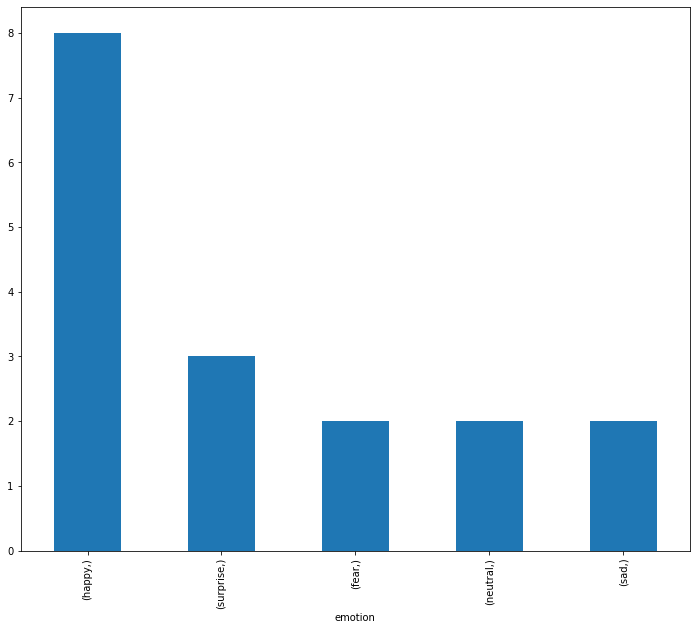

In [ ]:
Emotion_df.value_counts().plot.bar(figsize = (12,10))

# Speech Recognition

In [ ]:
#audio capture:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg -q
!pip install PyAudio -q
!pip -q install pydub -q

#speech recognition
!pip install SpeechRecognition -q
!pip install ffmpeg-python -q

Reading package lists...
Building dependency tree...
Reading state information...
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 0s (806 kB/s)
Selecting previously unsel

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

## Start Sound Recording:

**Question:** Tell us (in approximately 30 seconds or more) about an experience from your childhood where your talents were used. What was the situation, who was with you and what was the emotion at that time. What makes you think this was a talent? How does that experience translate to today?

In [ ]:
audio, sr = get_audio()

In [ ]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

## Get speech transccribed to text

In [ ]:
import speech_recognition as sr
import pprint

r = sr.Recognizer()

from os import path
AUDIO_FILE = ("/content/recording.wav")
# AUDIO_FILE = path.join(path.dirname(path.realpath(__file__)), "french.aiff")
# AUDIO_FILE = path.join(path.dirname(path.realpath(__file__)), "chinese.flac")

# use the audio file as the audio source
r = sr.Recognizer()
with sr.AudioFile(AUDIO_FILE) as source:
    audio = r.adjust_for_ambient_noise(source) 
    audio = r.record(source)  # read the entire audio file

# recognize speech using Google Speech Recognition
try:
    # for testing purposes, we're just using the default API key
    # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
    # instead of `r.recognize_google(audio)`
    captured_text = r.recognize_google(audio)
    print("Google Speech Recognition transcribed your audio to 'captured_text' ")
    
except sr.UnknownValueError:
    pp.pprint("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    pp.pprint("Could not request results from Google Speech Recognition service; {0}".format(e))

Google Speech Recognition transcribed your audio to 'captured_text' 


In [ ]:
pp = pprint.PrettyPrinter(width=90, compact=True)

print("Google Speech Recognition thinks you said: \n \n ")

pp.pprint(captured_text)

Google Speech Recognition thinks you said: 
 
 
('the question is tell us in approximately thirty seconds or more about an experience '
 'from your childhood where your talents were used what was the situation who was with '
 'you and what was the emotion has had time what makes you think that were the talent '
 'how does that experience translate to today and it was this two-story building I '
 "remember you have to walk up the stairs now I'm talk to you had all of these "
 'classrooms that kills kids of paints and I smell the brushes and the cans with water '
 'and all of the different things that they have there was a lot of your kind of scraps '
 "of different things and pains and everything's got it around the teachers were very "
 'nice and pleasant I painted and I remember winning the competition')


##try whisper AI

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[api,pipeline]


%%capture

from txtai.pipeline import Transcription

# Create transcription model
transcribe = Transcription()

In [ ]:
from IPython.display import Audio, display
from txtai.pipeline import Transcription

files = ["recording.wav"]

# Transcribe files
transcribe = Transcription("openai/whisper-base")
for text in transcribe(files):
  print("Whisper AI transcribed your recording successfully")
  captured_text1 = text

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Whisper AI transcribed your recording successfully


In [ ]:
pp = pprint.PrettyPrinter(width=90, compact=True)

print("Whisper AI thinks you said: \n \n ")

pp.pprint(captured_text1)

Whisper AI thinks you said: 
 
 
('So the question is tell us in approximately 30 seconds or more about an experience '
 'from your childhood where your talents were used. What was the situation? Who was with '
 'you and what was the emotion at that time? What makes you think that was a talent? How '
 'does that experience translate to today? So I remember in my childhood I went to art '
 'school and it was this two story')


# Analyze Results

Results from **Google transcribe**:

In [ ]:
!pip install spacy -q

import spacy
from collections import Counter
from string import punctuation

nlp = spacy.load("en_core_web_sm")

def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] 
    doc = nlp(text.lower()) 
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)
    return result


output = set(get_hotwords(captured_text))
most_common_list = Counter(output).most_common(10)
for item in most_common_list:
  print(item[0])

today
pains
cans
brushes
water
classrooms
nice
pleasant
situation
seconds


In [ ]:
!pip install wordcloud -q
!pip install matplotlib -q

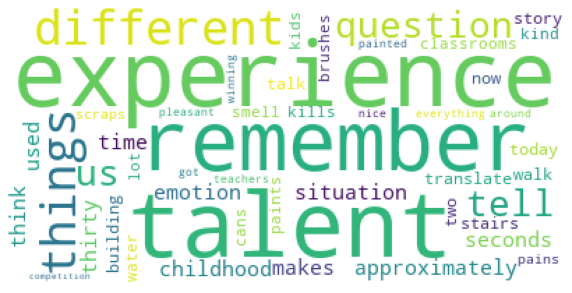

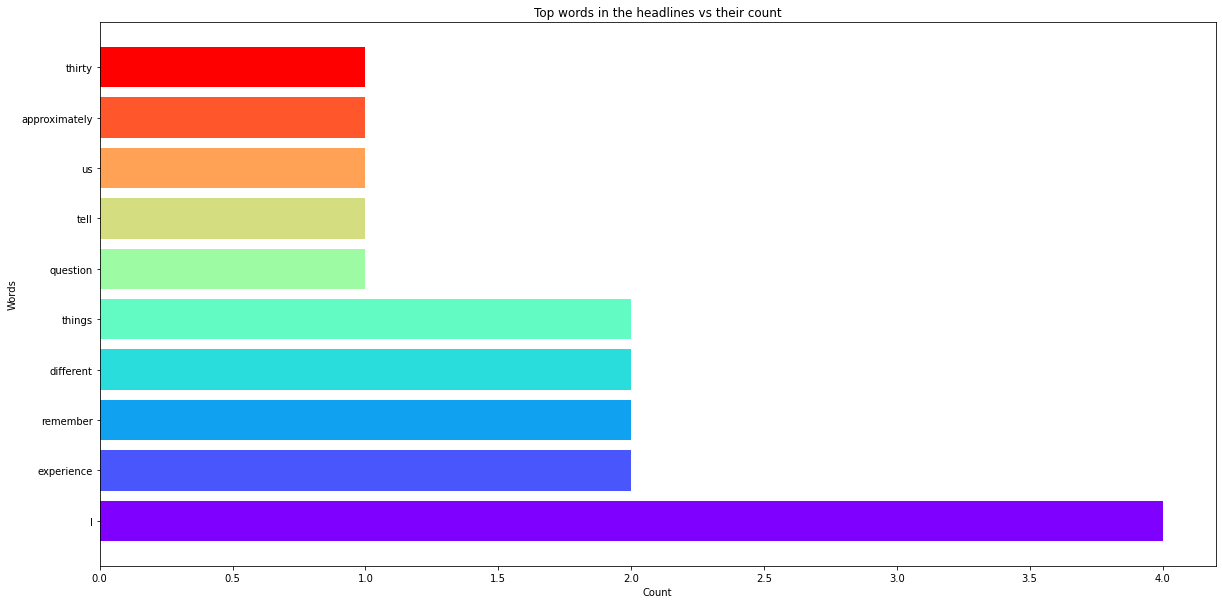

In [ ]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS

stopwords = STOPWORDS
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(captured_text)
rcParams['figure.figsize'] = 10, 20

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

filtered_words = [word for word in captured_text.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)
words = []
counts = []

for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10
plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
plt.show()

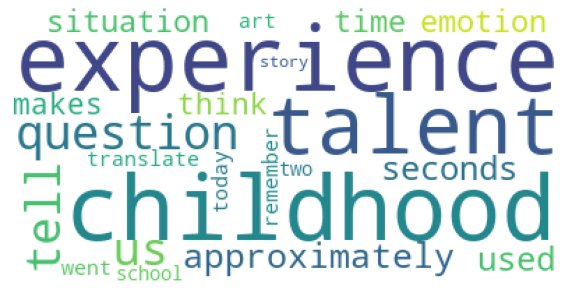

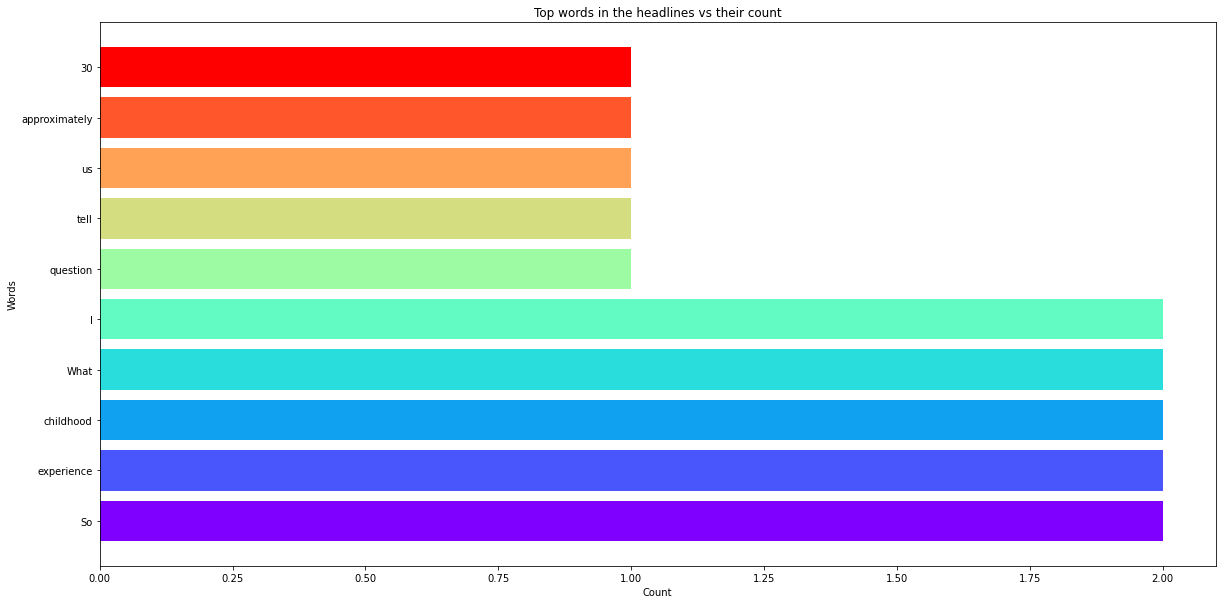

In [ ]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS

stopwords = STOPWORDS
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(captured_text1)
rcParams['figure.figsize'] = 10, 20

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

filtered_words = [word for word in captured_text1.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)
words = []
counts = []

for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10
plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
plt.show()